In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact, Visualization

%matplotlib inline

In [8]:
cd ../200608_Elsayed_Lowry-1101/reanalysis-2/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2


In [12]:
cp ../insertion-tree.qza insertion-tree.qza

In [14]:
ls

expr-group-metadata.tsv    nobloom_table.qza
filt-seq-taxa-barplot.qzv  samp-filt-seq-table.qza
insertion-tree.qza         taxonomy-gg.qza
nobloom_metadata.tsv


# Diversity
### Start by looking at reads/feature

>qiime feature-table summarize \
--i-table nobloom_table.qza \
--o-visualization nobloom_table.qzv \

In [16]:
viz = Visualization.load("nobloom_table.qzv")
viz

<visualization: Visualization uuid: 7af54aa8-f056-4148-abd7-d5b1249ab6be>

**The lowest number of reads above 10,000 is 13,056, so I will rarefy to 13,055.**

>qiime diversity core-metrics-phylogenetic \
--i-table nobloom_table.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13055 \
--m-metadata-file nobloom_metadata.tsv \
--output-dir core-diversity-results/

In [21]:
mkdir diversity-stats-results/

>qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-group.qzv

In [23]:
Visualization.load("diversity-stats-results/faith-group.qzv")

<visualization: Visualization uuid: 148091e8-02fa-4218-a49e-1628f2e9db89>

### Alpha group results
 - Chemotherapy
     - Not significant
     - p=0.267
     - H=1.23
 - CES-D
     - Not significant
     - p=0.091
     - H=2.86
 - FACT-Cog
     - Not significant
     - p=0.110
     - H=2.453
 - Stress scale
     - Not significant
     - p=0.498
     - H=0.458
 - PROMIS
     - Not significant
     - p=0.620
     - H=0.957

In [25]:
!qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-corr.qzv

Saved Visualization to: diversity-stats-results/faith-corr.qzv


In [26]:
Visualization.load("diversity-stats-results/faith-corr.qzv")

<visualization: Visualization uuid: 7c5dc032-b053-449d-9906-83f471760e58>

### Alpha Correlation results
 - Time difference
     - Not significant
     - p=0.085
     - Spearman r = 0.510
 - CES-D Total
     - SIGNIFICANT
     - p=0.033
     - Spearman r = -0.3903
 - FACT-Cog total
     - Not significant
     - p=0.116
     - Spearman r=0.2929
 - Stress scale
     - Not significant
     - p=0.247
     - Spearman r = -0.2182
 - PROMIS
     - Not significant
     - p=0.0648
     - Spearman r = -0.3414


In [62]:
metadata = pd.read_csv("nobloom_metadata.tsv", sep="\t", index_col="sampleid")

faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith.index = faith.index.astype(int)

time_faith = pd.concat([ faith, 
                         metadata[["Chemotherapy", "Time difference"]] ], 
                       axis=1)

#Make controls time diff=0, get rid of negative time diff
time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control", "Time difference"] = 0

time_faith.loc[(time_faith["Chemotherapy"]=="Breast Cancer") & 
               (time_faith["Time difference"] < 0),
                 "Time difference"] = np.NaN

#Drop nan faith values
time_faith.dropna(inplace=True)

time_faith_bc = time_faith[time_faith["Chemotherapy"]=="Breast Cancer"]

In [63]:
fit = np.polyfit(x = np.log(time_faith_bc["Time difference"]+0.01),
                 y = time_faith_bc["faith_pd"],
                 deg=1)

In [75]:
mkdir Figures

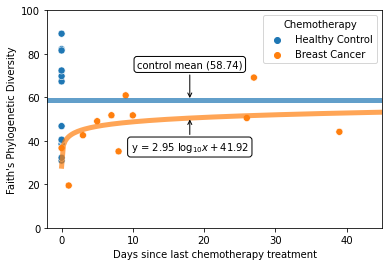

In [76]:
x = np.arange(0,45,0.25)+0.01
logy = fit[0] * np.log(x) + fit[1]


ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)

ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:blue",
           lw=5,
           alpha=0.7)

ax.plot(x,logy, lw=5, alpha=0.7, c="tab:orange")



annot_coords = (18, fit[0] * np.log(20) + fit[1])

ax.annotate("y = " + str(round(fit[0],2)) + r" $\log{_{10}}{x} + $" + str(round(fit[1], 2)), 
            xy=annot_coords, xytext=(18, fit[0] * np.log(20) + fit[1]-15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

grp2_mean = time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean()

ax.annotate("control mean (" + str(round(grp2_mean,2)) + ")", 
            xy=(18, grp2_mean), 
            xytext=(18, grp2_mean + 15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

ax.set_ylim(0,100)
ax.set_xlim(-2,45)
ax.set_ylabel("Faith's Phylogenetic Diversity")
ax.set_xlabel("Days since last chemotherapy treatment")

plt.savefig("Figures/faith_log_fit_annotated.pdf")
plt.show()

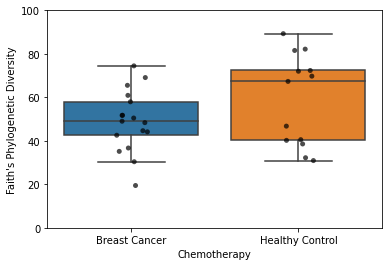

In [88]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                 y=faith,
                 showfliers=False)

sns.stripplot(x=metadata["Chemotherapy"],
              y=faith,
              palette=["black"]*2,
              alpha=0.7)

ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.savefig("Figures/faith_chemo.pdf")
plt.show()

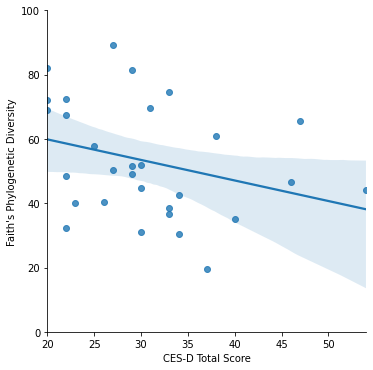

In [100]:
g = sns.lmplot(x="cesd_total",
                y="faith_pd",
                data=pd.concat([faith, metadata["cesd_total"]],
                              axis=1))

g.axes[0,0].set_ylim(0,100)
g.axes[0,0].set_ylabel("Faith's Phylogenetic Diversity")

g.axes[0,0].set_xlabel("CES-D Total Score")

plt.savefig("Figures/faith_cesd_corr.pdf")
plt.show()

### Beta Diversity